In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import f1_score, recall_score, precision_score
import json
import random

# Define the root directory of the dataset
root_dir = "E:/mediapipe_final"
#root_dir = "E:/openpose_temp"
# Define image size and other constants
IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CLASSES = 120  # Total number of classes
SUBSET_CLASSES = 2  # Number of classes in each subset
FRAMES_PER_VIDEO = 30
BATCH_SIZE = 8
EPOCHS = 40
learning_rate = 0.001

In [2]:
# Updated data augmentation with additional techniques
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

#Function to create a data generator with augmentation
def data_generator(file_list, class_subset, img_height, img_width, frames_per_video, batch_size=BATCH_SIZE, augment=False):
    class_indices = {cls_name: idx for idx, cls_name in enumerate(class_subset)}
    while True:
        X_batch = []
        y_batch = []

        for file_path, class_index in file_list:
            if class_names[class_index] not in class_subset:
                continue

            frames = []
            for frame in sorted(os.listdir(file_path)):
                frame_path = os.path.join(file_path, frame)
                image = load_img(frame_path, target_size=(img_height, img_width))
                image = img_to_array(image)
                
                if augment:
                    image = datagen.random_transform(image)

                frames.append(image)

            if len(frames) == frames_per_video:
                X_batch.append(frames)
                y_batch.append(class_indices[class_names[class_index]])

                if len(X_batch) == batch_size:
                    X_batch = np.array(X_batch, dtype=np.float32) / 255.0
                    y_batch = to_categorical(y_batch, num_classes=SUBSET_CLASSES)
                    yield X_batch, y_batch
                    X_batch = []
                    y_batch = []

# Load file paths and class indices
def load_file_paths(root_dir):
    file_paths = []
    class_names = sorted(os.listdir(root_dir))
    
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(root_dir, class_name)
        video_folders = os.listdir(class_dir)
        
        for video_folder in video_folders:
            video_path = os.path.join(class_dir, video_folder)
            file_paths.append((video_path, class_index))
    
    return file_paths, class_names

file_paths, class_names = load_file_paths(root_dir)



In [3]:
# Define a function to create the model
def create_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(FRAMES_PER_VIDEO, IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))  # Reduced number of LSTM units and added recurrent dropout
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))  # Adjusted dropout rate
    model.add(Dense(SUBSET_CLASSES, activation='softmax'))  # Output layer with number of classes units
    return model

In [4]:
import os
import json
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

# Function to evaluate the model on the validation set
def evaluate_model(model, val_generator, validation_steps):
    y_true = []
    y_pred = []
    for i in range(validation_steps):
        X_batch, y_batch = next(val_generator)
        y_true.append(np.argmax(y_batch, axis=1))
        y_pred.append(np.argmax(model.predict(X_batch), axis=1))
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred

# Train the model on subsets
def train_model(model, train_generator, val_generator, steps_per_epoch, validation_steps, subset_index):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath=f'best_model_subset_{subset_index}.keras', monitor='val_accuracy', save_best_only=True)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=learning_rate), metrics=['accuracy'])
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=val_generator, validation_steps=validation_steps, callbacks=[early_stopping, checkpoint])
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    return model, history.history, best_val_acc, best_val_loss

# Create subsets of classes
def create_class_subsets(class_names, subset_size):
    subsets = []
    for i in range(0, len(class_names), subset_size):
        subsets.append(class_names[i:i + subset_size])
    return subsets

class_subsets = create_class_subsets(class_names, SUBSET_CLASSES)
model = create_model()  # Initialize the model once
overall_histories = []
subset_best_val_accuracies = []
subset_best_val_losses = []
all_y_true = []
all_y_pred = []

for subset_index, class_subset in enumerate(class_subsets):
    print(f"Training on subset {subset_index + 1}/{len(class_subsets)}")
    subset_file_paths = [(path, idx) for path, idx in file_paths if class_names[idx] in class_subset]
    train_paths, val_paths = train_test_split(subset_file_paths, test_size=0.2, random_state=42)
    steps_per_epoch = len(train_paths) // BATCH_SIZE
    validation_steps = len(val_paths) // BATCH_SIZE
    train_generator = data_generator(train_paths, class_subset, IMG_HEIGHT, IMG_WIDTH, FRAMES_PER_VIDEO, BATCH_SIZE, augment=True)
    val_generator = data_generator(val_paths, class_subset, IMG_HEIGHT, IMG_WIDTH, FRAMES_PER_VIDEO, BATCH_SIZE, augment=False)
    model, history, best_val_acc, best_val_loss = train_model(model, train_generator, val_generator, steps_per_epoch, validation_steps, subset_index)
    overall_histories.append(history)
    subset_best_val_accuracies.append(best_val_acc)
    subset_best_val_losses.append(best_val_loss)
    y_true, y_pred = evaluate_model(model, val_generator, validation_steps)
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    model.save(f'model_subset_v1_{subset_index + 1}.keras')

# Compute and save overall metrics
f1 = f1_score(all_y_true, all_y_pred, average='weighted')
recall = recall_score(all_y_true, all_y_pred, average='weighted')
precision = precision_score(all_y_true, all_y_pred, average='weighted')
overall_cm = confusion_matrix(all_y_true, all_y_pred)
overall_accuracy = accuracy_score(all_y_true, all_y_pred)
metrics = {
    'f1_score': f1,
    'recall': recall,
    'precision': precision,
    'overall_best_val_accuracy': np.mean(subset_best_val_accuracies),
    'overall_best_val_loss': np.mean(subset_best_val_losses),
    'accuracy': overall_accuracy
}
save_dir = 'mediapipe_models'
os.makedirs(save_dir, exist_ok=True)
metrics_path = os.path.join(save_dir, 'ensemble_metrics_v1_mdediapipe.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)
np.save(os.path.join(save_dir, 'overall_confusion_matrix_mediapipe.npy'), overall_cm)
final_model_path = os.path.join(save_dir, 'final_model_mediapipe_v1.keras')
model.save(final_model_path)
history_path = os.path.join(save_dir, 'ensemble_history_v1_mediapipe.json')
ensemble_history = {i: history for i, history in enumerate(overall_histories)}
with open(history_path, 'w') as f:
    json.dump(ensemble_history, f)
print(f"Overall Metrics: F1 Score: {f1}, Recall: {recall}, Precision: {precision}, Accuracy: {overall_accuracy}")
print(f"Overall best validation accuracy: {np.mean(subset_best_val_accuracies):.4f}")
print(f"Overall best validation loss: {np.mean(subset_best_val_losses):.4f}")


D:\anaconda\envs\tf\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training on subset 1/60
Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - accuracy: 0.3345 - loss: 0.8231 - val_accuracy: 0.6250 - val_loss: 0.6925
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5830 - loss: 0.6982 - val_accuracy: 0.5000 - val_loss: 0.6957
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4780 - loss: 0.7277 - val_accuracy: 0.3750 - val_loss: 0.6931
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5039 - loss: 0.6856 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3217 - loss: 0.7215 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5917 - loss: 0.6862 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3854 - loss: 0.7167 - val_accuracy: 0.6250 - val_loss: 0.6929
Epoch 8/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5940 - loss: 0.6941 - val_accuracy: 0.6250 - va

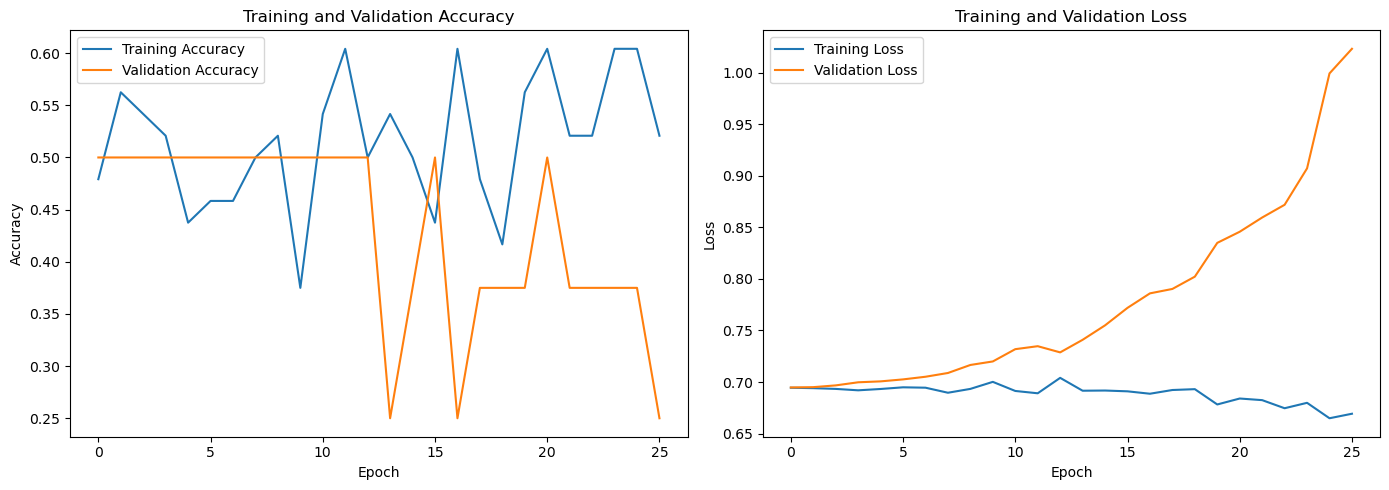

In [5]:
import os
import json
import matplotlib.pyplot as plt

# Define the directory where the models and data are saved
model_dir = 'mediapipe_models'

# Load training histories
history_path = os.path.join(model_dir, 'ensemble_history_v1_mediapipe.json')
try:
    with open(history_path, 'r') as f:
        histories = json.load(f)
except IOError:
    print("Error opening the history file. Please check the file path and permissions.")
    histories = {}
except json.JSONDecodeError:
    print("Error decoding the history file. Please check the file content.")
    histories = {}

if not histories:
    print("No data found in histories. Exiting the plotting.")
else:
    # Plotting
    plt.figure(figsize=(14, 5))

    # Assuming you want to plot only the last subset
    last_key = sorted(histories.keys())[-1]  # Get the last key in the sorted list of keys
    history = histories.get(last_key)

    if history is not None:
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("No history available for the last subset.")
